<a href="https://colab.research.google.com/github/Lucia1009/TFG-Plataforma-para-la-prediccion-de-potencia-electrica-generada-en-parques-eolicos/blob/desarrollo/modelos/Series_temporales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



*   SVM
*   *ARIMA/SARIMA*
*   Redes neuronales:

  *   TLNN, SANN
  *   RNN (redes neuronales recurrentes)
  *   LSTM (Memoria a corto plazo. También es recurrente)
  *   CNN (Redes neuronales convolucionales)









                  
                  
                  

In [1]:
!pip install dash -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import dash
from dash import Dash, html, dcc, Input, Output
import plotly.express as px
import plotly.graph_objects as go

In [2]:
def cargar_datos():

  from google.colab import drive
  drive.mount('/content/drive')

  df1=pd.read_csv('/content/drive/MyDrive/TFG/datos_variaciones/Report_ElValle_cada_minuto_sinteticos_con_esperas_transitorio_aa.csv', delimiter=";",decimal=".",skiprows = [1])
  df2=pd.read_csv('/content/drive/MyDrive/TFG/datos_variaciones/Report_ElValle_cada_minuto_sinteticos_con_esperas_transitorio_ab.csv', delimiter=";",decimal=".",skiprows = [1])
  df3=pd.read_csv('/content/drive/MyDrive/TFG/datos_variaciones/Report_ElValle_cada_minuto_sinteticos_con_esperas_transitorio_ac.csv', delimiter=";",decimal=".",skiprows = [1])
  df4=pd.read_csv('/content/drive/MyDrive/TFG/datos_variaciones/Report_ElValle_cada_minuto_sinteticos_con_esperas_transitorio_ad.csv', delimiter=";",decimal=".",skiprows = [1])
  df5=pd.read_csv('/content/drive/MyDrive/TFG/datos_variaciones/Report_ElValle_cada_minuto_sinteticos_con_esperas_transitorio_ae.csv', delimiter=";",decimal=".",skiprows = [1])
  df6=pd.read_csv('/content/drive/MyDrive/TFG/datos_variaciones/Report_ElValle_cada_minuto_sinteticos_con_esperas_transitorio_af.csv', delimiter=";",decimal=".",skiprows = [1])
  df7=pd.read_csv('/content/drive/MyDrive/TFG/datos_variaciones/Report_ElValle_cada_minuto_sinteticos_con_esperas_transitorio_ag.csv', delimiter=";",decimal=".",skiprows = [1])
  df8=pd.read_csv('/content/drive/MyDrive/TFG/datos_variaciones/Report_ElValle_cada_minuto_sinteticos_con_esperas_transitorio_ah.csv', delimiter=";",decimal=".",skiprows = [1])
  df9=pd.read_csv('/content/drive/MyDrive/TFG/datos_variaciones/Report_ElValle_cada_minuto_sinteticos_con_esperas_transitorio_ai.csv', delimiter=";",decimal=".",skiprows = [1])
  df10=pd.read_csv('/content/drive/MyDrive/TFG/datos_variaciones/Report_ElValle_cada_minuto_sinteticos_con_esperas_transitorio_aj.csv', delimiter=";",decimal=".",skiprows = [1])
  df11=pd.read_csv('/content/drive/MyDrive/TFG/datos_variaciones/Report_ElValle_cada_minuto_sinteticos_con_esperas_transitorio_ak.csv', delimiter=";",decimal=".",skiprows = [1])
  df12=pd.read_csv('/content/drive/MyDrive/TFG/datos_variaciones/Report_ElValle_cada_minuto_sinteticos_con_esperas_transitorio_al.csv', delimiter=";",decimal=".",skiprows = [1])
  df13=pd.read_csv('/content/drive/MyDrive/TFG/datos_variaciones/Report_ElValle_cada_minuto_sinteticos_con_esperas_transitorio_am.csv', delimiter=";",decimal=".",skiprows = [1])
  df14=pd.read_csv('/content/drive/MyDrive/TFG/datos_variaciones/Report_ElValle_cada_minuto_sinteticos_con_esperas_transitorio_an.csv', delimiter=";",decimal=".",skiprows = [1])

  df=pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,df13,df14])

  return df

df=cargar_datos()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def filtrar_datos(df):
  df.head()

  ## TIEMPO/RÉGIMEN ESTACIONARIO
  # Filtro para el régimen estacionario
  datos=df[(df['TIME'] % 600==540)]

  #Reseteo el índice y quito la primera fila
  datos = datos.reset_index(drop=True)
  datos=datos.drop(0)

  ## WD
  #Obtener la dirección wd mímina y máxima de datos_filtrado
  datos = datos[datos['wd'] >= 0]
  datos = datos[datos['wd'] < 360]

  ## WF_POWER
  # datos_filtrado = datos_filtrado[datos_filtrado['WF_Power'] >= 0]
  datos[datos['WF_Power'] < 0] = 0  # Mejores resultados

  ## WS
  # datos_filtrado = datos_filtrado[datos_filtrado['ws'] >= 0]
  datos[datos['ws'] < 0] = 0  # Mejores resultados

  datos_filtrado=datos[['ws', 'wd', 'WF_Power_SP', 'WF_Power']]

  return datos_filtrado

datos_filtrado=filtrar_datos(df)

In [4]:
# fig = go.Figure()

# fig.add_trace(go.Scatter(x=datos_filtrado['TIME'], y=datos_filtrado['WF_Power_SP'],
#                     mode='markers',
#                     name='WF_Power'))

# fig.update_layout(
#     xaxis=dict(
#         rangeslider=dict(
#             visible=True
#         ),
#         type="linear"
#     )
# )

# fig.show()


In [5]:
# Genera columnas con las variables de tiempo -1 y +1
def obtener_momentos_tiempo(datos, salto_pasado=1, salto_futuro=1):
  vars=datos.columns
  cols, name_cols = [],[]

  for i in range(salto_pasado,0,-1):
    cols.append(datos.shift(i))
    name_cols += [('%s(t-%d)' % (nom, i)) for nom in vars]
  for i in range(0,salto_futuro):
    cols.append(datos.shift(-i))
    if i == 0:
      name_cols += [('%s(t)' % (nom)) for nom in vars]
    else:
      name_cols += [('%s(t+%d)' % (nom, i)) for nom in vars]

  res = pd.concat(cols, axis=1)
  res.columns = name_cols
  res.dropna(inplace=True)

  return res
salto_pasado=4
salto_futuro=1
momentos_tiempo=obtener_momentos_tiempo(datos_filtrado, salto_pasado, salto_futuro)
momentos_tiempo.head()

,ws(t-4),wd(t-4),WF_Power_SP(t-4),WF_Power(t-4),ws(t-3),wd(t-3),WF_Power_SP(t-3),WF_Power(t-3),ws(t-2),wd(t-2),...,WF_Power_SP(t+1),WF_Power(t+1),ws(t+2),wd(t+2),WF_Power_SP(t+2),WF_Power(t+2),ws(t+3),wd(t+3),WF_Power_SP(t+3),WF_Power(t+3)
5,11.293976,142.721948,16663543.2,16386284.4,11.042021,148.116548,16663543.2,16662333.9,12.239905,154.965457,...,16663543.2,16649963.1,14.150793,184.231505,16663543.2,16733355.7,12.907097,198.395895,16663543.2,16646185.1
6,11.042021,148.116548,16663543.2,16662333.9,12.239905,154.965457,16663543.2,16670889.9,11.027095,160.603557,...,16663543.2,16733355.7,12.907097,198.395895,16663543.2,16646185.1,14.236895,205.573434,16663543.2,16711907.3
7,12.239905,154.965457,16663543.2,16670889.9,11.027095,160.603557,16663543.2,16656144.5,13.186831,167.448465,...,16663543.2,16646185.1,14.236895,205.573434,16663543.2,16711907.3,15.670888,216.595138,16663543.2,16707266.8
8,11.027095,160.603557,16663543.2,16656144.5,13.186831,167.448465,16663543.2,16684826.6,11.539128,177.982182,...,16663543.2,16711907.3,15.670888,216.595138,16663543.2,16707266.8,17.514856,230.779891,16663543.2,16692833.5
9,13.186831,167.448465,16663543.2,16684826.6,11.539128,177.982182,16663543.2,16649963.1,14.150793,184.231505,...,16663543.2,16707266.8,17.514856,230.779891,16663543.2,16692833.5,15.165184,231.732925,16663543.2,16579310.8


In [8]:
def datos_to_x_y(datos, salto):

  if salto==1:
    Y=datos['WF_Power(t)']
    X=datos.drop(['WF_Power(t)'],axis=1)
  else:
    salto=salto-1
    Y=datos[f'WF_Power(t-{salto})']
    X=datos.drop([f'WF_Power(t-{salto})'],axis=1)

  return X,Y



def obtener_train_test(datos, salto, porcentaje=0.8):
  train_size = int(len(datos) * porcentaje)
  test_size = len(datos) - train_size
  train, test = datos.iloc[0:train_size,:], datos.iloc[train_size:len(datos),:]

  train_X, train_Y = datos_to_x_y(train, salto)
  test_X, test_Y = datos_to_x_y(test, salto)

  # Normalizamos los datos
  scaler = MinMaxScaler(feature_range=(0, 1))
  train_X = scaler.fit_transform(train_X)
  test_X = scaler.transform(test_X)

  train_X = np.reshape(train_X, (train_X.shape[0], salto, train_X.shape[1]))
  test_X = np.reshape(test_X, (test_X.shape[0], salto, test_X.shape[1]))

  return train_X, train_Y, test_X, test_Y, scaler

train_X, train_Y, test_X, test_Y, scaler = obtener_train_test(momentos_tiempo, salto_futuro)

ValueError: cannot reshape array of size 3562928 into shape (222683,4,16)

In [ ]:
# Creamos el modelo
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=['R2Score','mae', 'mse'])

history = model.fit(train_X, train_Y, epochs=20, batch_size=72, validation_data=(test_X, test_Y), verbose=2, shuffle=False)

model.evaluate(test_X, test_Y)

In [ ]:
from numpy import concatenate
from pandas import concat

yhat = model.predict(test_X)

# Añadimos una nueva dimension a yhat
yhat = yhat.reshape((yhat.shape[0], 1, yhat.shape[1]))

# Eliminamos la dimension del medio en test_X[:, 1:]
test_X_nuevo=test_X[:, 0, 1:]

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:,:,1:]), axis=2) #Concatenamos los datos con la misma dimension
inv_yhat = inv_yhat.reshape(inv_yhat.shape[0], inv_yhat.shape[2]) # Reajustamos los datos para que coincidan con lo que espera el scaler
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_Y.values.reshape((len(test_Y), 1))
inv_y = concatenate((test_y, test_X_nuevo), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

print(len(test_Y))
print(len(yhat))

fig = go.Figure()

fig.add_trace(go.Scatter( y=inv_yhat,
                    mode='markers',
                    name='WF_Power_PREDICHA', marker_color='red'))

fig.add_trace(go.Scatter( y=inv_y,
                    mode='markers',
                    name='WF_Power_REAL', marker_color='blue'))

fig.update_layout(
    xaxis=dict(
        rangeslider=dict(
            visible=True
        ),
        type="linear"
    )
)

fig.show()

# Guardar en un html la figura
fig.write_html("serie_temporal.html")

![imagen](/content/drive/MyDrive/TFG/series temporales.jpg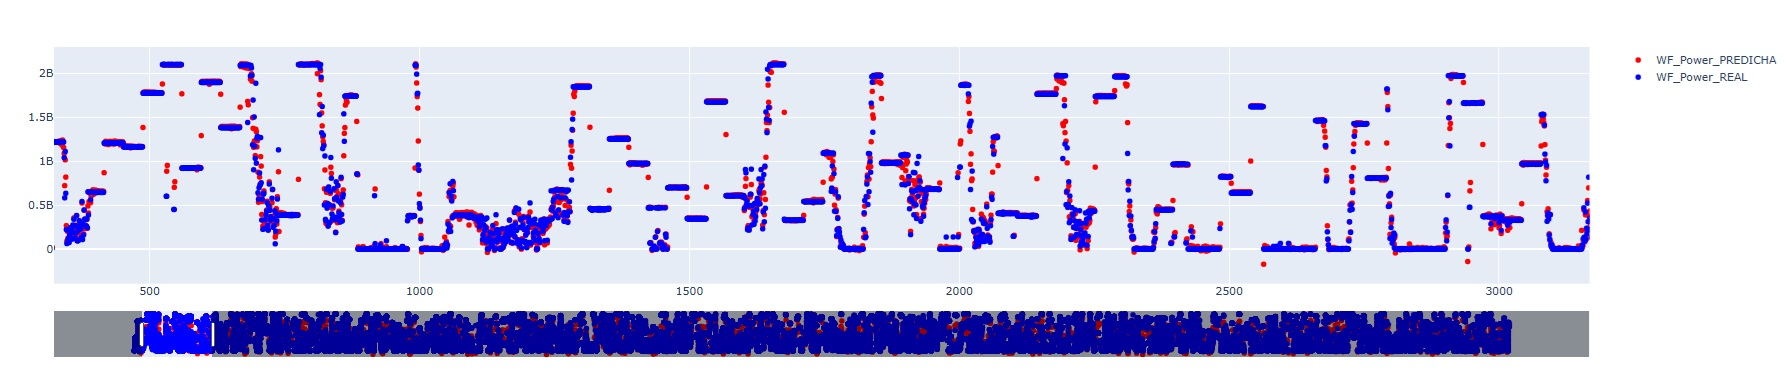)